In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import

In [0]:
import os

# change to path
PATH='/content/drive/My Drive/Colab Notebooks/christies'
os.chdir(PATH)

In [0]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import gc
import re

import spacy
from spacy.matcher import Matcher
from spacy.matcher import PhraseMatcher
from spacy.tokenizer import Tokenizer

from tqdm import tqdm_notebook as tqdm

from PIL import Image

import warnings
warnings.simplefilter(action='ignore')

In [0]:
# !pip install pandarallel

# from pandarallel import pandarallel
# pandarallel.initialize()    

## Read in

In [0]:
READ_H = True # load the csv with image hash

In [0]:
if READ_H:
    df = pd.read_csv('dataset/art_h.csv') # post_war_art_h
else:
    df = pd.read_csv('dataset/post_war_art_clean.csv')    
    # !pip install imagehash
    # import imagehash

In [7]:
df.head()

,title,auction_id,auction_loc,sale,currency,parent,auction_start,auction_end,item_id,item_name,item_past,artist,item_des,item_prov,img_url,exchange_rate,low_est,high_est,realized_price,p_h,avg_h
0,Post-War and Contemporary Art Day Auction,17194,London,12663250,GBP,Post-War-and-Contemporary-Art-28093,2019-06-26,2019-06-26,101,Still Life,Nicolas Party (b.1980),Nicolas Party,"""Nicolas Party (b.1980) Still Life signed and...","Private Collection, Italy.",https://www.christies.com/img/LotImages/2019/C...,0.779445,20000.0,40000.0,150000.0,9fe06a85ad17943a,ffffbfbf9f1e0000
1,Post-War and Contemporary Art Day Auction,17194,London,12663250,GBP,Post-War-and-Contemporary-Art-28093,2019-06-26,2019-06-26,102,It's My Pot of Gold,Shara Hughes (b. 1981),Shara Hughes,"""Shara Hughes (b. 1981) It's My Pot of Gold s...","Private Collection, London. Anon. sale, Philli...",https://www.christies.com/img/LotImages/2019/C...,0.779445,25000.0,35000.0,125000.0,ee66993dc0d65219,0001f0f4a000bfff
2,Post-War and Contemporary Art Day Auction,17194,London,12663250,GBP,Post-War-and-Contemporary-Art-28093,2019-06-26,2019-06-26,103,(black 14),Shio Kusaka (B. 1972),Shio Kusaka,'Shio Kusaka (B. 1972) (black 14) stoneware ...,"The Modern Institute, Glasgow. Acquired from t...",https://www.christies.com/img/LotImages/2019/C...,0.779445,7000.0,9000.0,11875.0,b4c3cb3cc9328f32,ffe7e7c3c3c3c3ff
3,Post-War and Contemporary Art Day Auction,17194,London,12663250,GBP,Post-War-and-Contemporary-Art-28093,2019-06-26,2019-06-26,104,(black 13),Shio Kusaka (B. 1972),Shio Kusaka,'Shio Kusaka (B. 1972) (black 13) stoneware ...,"The Modern Institute, Glasgow. Acquired from t...",https://www.christies.com/img/LotImages/2019/C...,0.779445,4000.0,6000.0,5625.0,ec8f92608f2a7c95,ffff838181c1e7ff
4,Post-War and Contemporary Art Day Auction,17194,London,12663250,GBP,Post-War-and-Contemporary-Art-28093,2019-06-26,2019-06-26,105,(ink 3),Shio Kusaka,Shio Kusaka,'Shio Kusaka (ink 3) porcelain 9 ½ x 4 ¾ x 4...,"Blum & Poe, Los Angeles. Acquired from the ab...",https://www.christies.com/img/LotImages/2019/C...,0.779445,5000.0,8000.0,22500.0,ec8cd2929373c6cc,ffc3c3c3c3c3c3ff


In [8]:
len(df)

48343

## Issue
Image file is too large and crashes in Google Colab, the images were separated into two folders. This will only be run once.

In [0]:
# os.chdir('dataset')
# os.listdir()

# !mkdir images_2

# files = os.listdir('dataset/images_1')

# half_len = len(files)

# half_len

# import shutil

# for i in tqdm(range(half_len)):
#     src = 'images/' + files[i]
#     dst = 'images_2/' + files[i]
#     shutil.move(src, dst)    

Retrieving an image is slightly cumbersome. Hence, a helper function is created to handle this. `plot2` is another helper function to show two images.

In [0]:
def get_img(url):
    name = url.split('/')[-1]
    
    # check if it's in first images folder
    filename_1 = 'dataset/images_1/' + name
    
    # check if it's in second images folder
    filename_2 = 'dataset/images_2/' + name
    
    if os.path.exists(filename_1): 
        img = Image.open(filename_1)
        return img

    elif os.path.exists(filename_2):
        img = Image.open(filename_2)
        return img
        
    else: return -1
    
def plot2(item1, item2):    
    fig = plt.figure(figsize=(8, 16))
    fig.add_subplot(1,2,1)
    plt.imshow(get_img(item1))
    fig.add_subplot(1,2, 2)
    plt.imshow(get_img(item2))
    plt.show()    

## EDA

### Item


Is there any item that has been auctioned more than once, i.e., exchanged hands?

Approach 1: Find duplicates by image hash

This approach is to look for similar items is by the imega hashes. This can be done by using the `imagehash` library.

In [0]:
def get_img_hash(url):
    img = url.split('/')[-1]
    
    # check if it's in first images folder
    filename_1 = 'dataset/images_1/' + img
    
    # check if it's in second images folder
    filename_2 = 'dataset/images_2/' + img
    
    if os.path.exists(filename_1): 
        image = Image.open(filename_1)
        return str(imagehash.phash(image)), str(imagehash.average_hash(image))

    elif os.path.exists(filename_2):
        image = Image.open(filename_2)
        return str(imagehash.phash(image)), str(imagehash.average_hash(image))
    
    return np.nan, np.nan

In [0]:
if not READ_H:
    # use multiprocessing for apply function    
    hashes = df['img_url'].parallel_apply(get_img_hash)
    
    df['p_h'] = np.array([h[0] for h in hashes])
    df['avg_h'] = np.array([h[1]for h in hashes])
    
    # df.to_csv('dataset/post_war_art_h.csv', index=False)

In [13]:
dups = df[df.duplicated(subset=['p_h'])].reset_index(drop=True)

dups.replace({'p_h': 'nan', 'avg_h': 'nan'}, np.nan, inplace=True)

dups.dropna(subset=['p_h', 'avg_h'], inplace=True)

dups = dups['p_h'].value_counts()

dups.loc[(dups > 1)].head()

8da85bafa834da8a    389
9c69b362c99c49b6     29
bbc26934c46b9663     29
86710e793d69c63c     29
a627535a9d0ed8d8     29
Name: p_h, dtype: int64

Apparently, the the hash value of `8da85bafa834da8a` appears 389 times, indicating that there might be a mistake in the `html` setup of the page that differs from convention.  Same goes for other 4 hashes. They shall be removed as follows.

In [14]:
normal_dups = dups.loc[(dups > 1) & (dups < 29)]

normal_dups.iloc[np.r_[:3, -3:0]]

e9a4965a8ce16b8d    4
eec0c42f999b3b60    3
c0ce3eb1d3612dca    3
eee4d115911e915b    2
bdc2c06e873dc2d8    2
c4cb4fb4701f9d60    2
Name: p_h, dtype: int64

In [15]:
dup_hashes = list(normal_dups.index)

# ensure the items are sold on different auction start time
g = df[df['p_h'].isin(dup_hashes)].groupby('p_h')['auction_start'].describe()

resold = g[g['unique'] > 1]

print('Number of duplicate items:', len(resold))

resold.reset_index().head()

Number of duplicate items: 4


,p_h,count,unique,top,freq
0,caeb6d3cb6b060d0,4,4,2006-04-06,1
1,ccec2398730cb69b,3,3,2016-09-29,1
2,eb95946a9c69a564,3,3,2017-04-05,1
3,ef45b0aab5af4114,4,4,2016-09-29,1


The above seems more normal for same hashes, i.e., items that appear more than once. So the actual number of items that have exchanged hands is, in fact, 3 considering that items are sold on different days. 

N.B.: The other image is corrupted and will not be displayed below.

Display the images.

In [0]:
def show_img(df, h, p_h=True):
    # get the list of img_url that
    # corresponds to the perception hash
    if p_h:
        ls = df[df['p_h'] == h]['img_url'].tolist()
    else:
        ls = df[df['avg_h'] == h]['img_url'].tolist()      

    plot2(ls[0], ls[1])

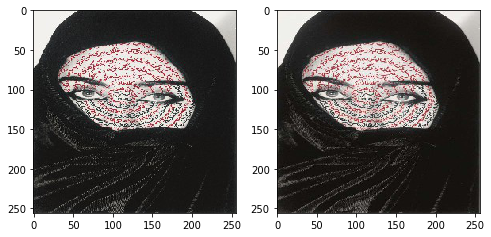

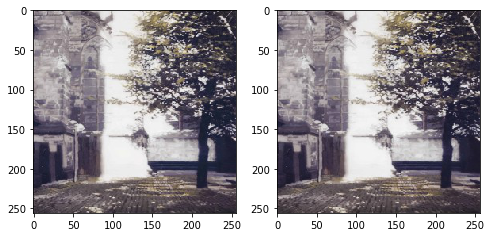

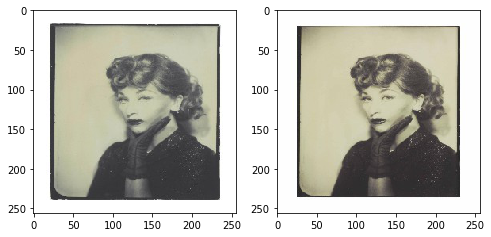

In [17]:
show_img(df, 'caeb6d3cb6b060d0')

show_img(df, 'ccec2398730cb69b')

show_img(df, 'eb95946a9c69a564')

Approach 2: Find duplicates by text

Only 3 items have been resold seem too little. Consider checking whether does the artwork in the dataframe have duplicate artist name, item name, and item provenance.

In [18]:
dups = df[df.duplicated(subset=['artist', 'item_name', 'item_prov'], 
                        keep=False)].dropna()

# remove Untitled paintings
dups = dups[~dups['item_name'].isin(['Untitled'])]

g = dups.groupby(['item_name'])['auction_start'].describe()

# ensure the items are sold on different auction start time
resold = g[g['unique'] > 1]

print('Number of duplicate items:', len(resold))

resold.reset_index().head()

Number of duplicate items: 73


,item_name,count,unique,top,freq
0,(i) Every... Bernd and Hilla Becher Prison Typ...,2,2,2013-02-14,1
1,"101 Drive-In Ventura, 1993",2,2,2006-05-10,1
2,35 Steel Staple Run,2,2,2014-02-14,1
3,ART,2,2,2011-11-09,1
4,Abstraktes Bild,2,2,2015-10-16,1


A look into one of the duplicate items, *Crio+Cristo+Critico*.

In [19]:
examples = df[df['item_name'] == 'Crio+Cristo+Critico']

examples

,title,auction_id,auction_loc,sale,currency,parent,auction_start,auction_end,item_id,item_name,item_past,artist,item_des,item_prov,img_url,exchange_rate,low_est,high_est,realized_price,p_h,avg_h
42150,Post War and Contemporary Art,2508,Milan,10659184,EUR,Post-War-and-Contemporary-21635,2008-05-26,2008-05-26,268,Crio+Cristo+Critico,Luigi Ontani (N. 1943),Luigi Ontani,'Luigi Ontani (N. 1943) Crio+Cristo+Critico ...,"Galleria dell'Oca, Roma ivi acquisito dall'att...",https://www.christies.com/img/LotImages/2008/R...,0.643972,10000.0,15000.0,12800.0,fe8da04685cb869b,e7819900008181e7
43417,Post War and Contemporary Art,2503,Milan,13883633,EUR,Post-War-and-Contemporary-20970,2007-11-27,2007-11-27,288,Crio+Cristo+Critico,Luigi Ontani (N. 1943),Luigi Ontani,'Luigi Ontani (N. 1943) Crio+Cristo+Critico ...,"Galleria dell'Oca, Roma ivi acquisito dall'att...",https://www.christies.com/img/LotImages/2007/R...,0.684112,10000.0,15000.0,19100.0,ff8da066854a8793,e7c19988008081e7


Interestingly, both paintings do not have the same hash. *Crio+Cristo+Critico* was first sold at 19,100 EUR in 2007 and resold for 12,800 EUR in 2008.

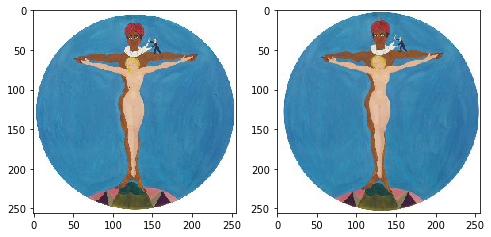

In [20]:
item1 = df[df['p_h'] == 'fe8da04685cb869b']['img_url'].item()
item2 = df[df['p_h'] == 'ff8da066854a8793']['img_url'].item()

plot2(item1, item2)

A look into Andy Warhol's *Dollar Sign*.

In [21]:
df[df['item_name'] == 'Dollar Sign'].describe()['realized_price']

count    3.900000e+01
mean     9.700449e+05
std      1.903003e+06
min      3.245000e+04
25%      1.596250e+05
50%      3.145000e+05
75%      6.075000e+05
max      8.789000e+06
Name: realized_price, dtype: float64

Looking at the `count`, it can be seen that there are 39 *Dollar Sign* paintings, with the highest price sold at 8.789 mil USD and the lowest sold at 32,450 USD.

In [22]:
min_idx = df[df['item_name'] == 'Dollar Sign']['realized_price'].argmin()
max_idx = df[df['item_name'] == 'Dollar Sign']['realized_price'].argmax()

df.iloc[[min_idx, max_idx]]

,title,auction_id,auction_loc,sale,currency,parent,auction_start,auction_end,item_id,item_name,item_past,artist,item_des,item_prov,img_url,exchange_rate,low_est,high_est,realized_price,p_h,avg_h
33985,Post-War and Contemporary Art Day Auction,7978,London,13179325,GBP,Post-War-and-Contemporary-Art-23145,2011-06-29,2011-06-29,258,Dollar Sign,Andy Warhol (1928-1987),Andy Warhol,"""Andy Warhol (1928-1987) Dollar Sign with ...","The Estate of Andy Warhol, New York. Martin La...",https://www.christies.com/img/LotImages/2011/C...,0.616827,25000.0,35000.0,32450.0,eac4931b9c26e399,fff7e1f1d9c181a5
17156,Post-War and Contemporary Art Evening Sale,3740,New York,658532000,USD,Post-War-and-Contemporary-Art-25300,2015-05-13,2015-05-13,56,Dollar Sign,Andy Warhol (1928-1987),Andy Warhol,'Andy Warhol (1928-1987) Dollar Sign stamped...,"Leo Castelli Gallery, New York Anon. sale; Sot...",https://www.christies.com/img/LotImages/2015/N...,1.000000,7500000.0,8500000.0,8789000.0,bdc7c2bc43693486,ffffc3818383c300


In [0]:
low, high = df.iloc[[min_idx, max_idx]]['img_url'].tolist()

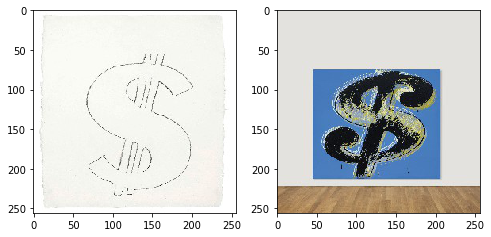

In [24]:
plot2(low, high)

### Sizes/dimensions

In [0]:
dim_pat = [
    [{"POS": {"IN": ["NOUN", "NUM"]}},
     {"POS": "SYM"}, 
     {"POS": "NUM"},
     {'POS': "SYM", "OP": "*"},
     {"POS": "NUM", "OP": "*"},
     {"LOWER": "c"},
     {"LOWER": "m"}
    ],
    
    [{"LOWER": "c"},
     {"LOWER": "m"},
     {"POS": "NUM"},
     {'POS': "SYM", "OP": "*"},
     {"POS": "NUM", "OP": "*"}     
    ]
    
]

def pipe_matcher(matcher, docs):
    for doc in docs:
        matches = matcher(doc)
        if len(matches) > 0:
            match_id, start, end = matches[-1]    
            span = doc[start:end]  
            yield span.text    
            
        else:
            yield ''   

In [0]:
prefix_re = re.compile(r'''^[(]''')
infix_re = re.compile(r'''[cm|x]''')

def custom_tokenizer(nlp):
    return Tokenizer(nlp.vocab, prefix_search=prefix_re.search,
                                infix_finditer=infix_re.finditer)

nlp = spacy.load('en_core_web_sm')

nlp.tokenizer = custom_tokenizer(nlp)

In [0]:
docs = nlp.pipe(df['item_des'])

matcher = Matcher(nlp.vocab)
matcher.add("dim_pat", None, *dim_pat)  # add patterns

mt = pipe_matcher(matcher, docs)

In [28]:
%%time
df['dims'] = tqdm(list(mt))


CPU times: user 5min 18s, sys: 4.01 s, total: 5min 22s
Wall time: 5min 22s


In [0]:
def clean_dims(s):
    del_brackets = s.split('(')
    del_cm = [d.split('cm') for d in del_brackets][-1] # [c.split('cm') for c in s][-1]
    for d in del_cm:
        if d != '': 
            del_space = d
            del_multi = del_space.split('x') 
            try:
                dims = [float(num) for num in del_multi if num != '' and num != ' ']
                return dims
            except:
                return np.nan
    return np.nan

df['dims_float'] = df['dims'].apply(clean_dims)

In [30]:
# get a df that only has dims properly recorded
dim_df = df[~df['dims_float'].isna()]

pct = (len(dim_df)/len(df)) * 100
print('Successfully extracted {:.2f}% of artwork\'s dimension!'.format(pct))

Successfully extracted 82.31% of artwork's dimension!


In [0]:
def get_area_vol(dims):
    if len(dims) == 2:
        return [dims[0] * dims[1], -1]
    elif len(dims) == 3:
        return [-1, dims[0] * dims[1] * dims[2]]
    return [np.nan, np.nan]

areas_volumes = dim_df['dims_float'].apply(get_area_vol)

In [0]:
dim_df['surface_area'] = [av[0] for av in areas_volumes]
dim_df['volume'] = [av[1] for av in areas_volumes]

In [0]:
suarea_df = dim_df[dim_df['surface_area'] > 0]
volume_df = dim_df[dim_df['volume'] > 0]

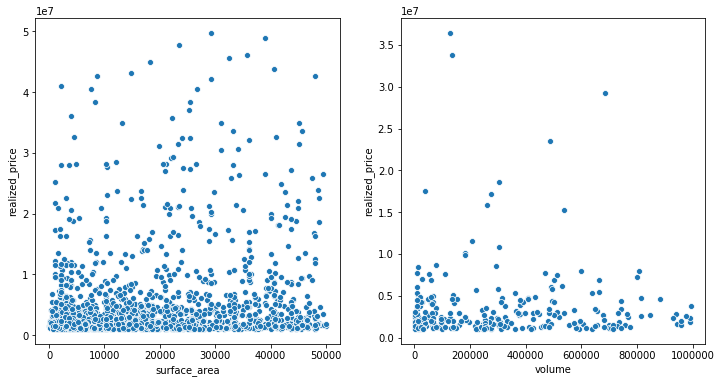

In [34]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

sns.scatterplot(x='surface_area',
                y='realized_price',
                ax=ax1,
                data=suarea_df[(suarea_df['surface_area'] < 50_000) &
                               (suarea_df['realized_price'] > 1_000_000) &
                               (suarea_df['realized_price'] < 50_000_000)])

sns.scatterplot(x='volume',
                y='realized_price',
                ax=ax2,
                data=volume_df[(volume_df['volume'] < 1_000_000) &
                               (volume_df['realized_price'] > 1_000_000) &
                               (volume_df['realized_price'] < 50_000_000)])

plt.show()

There is no clear relationship between surface area or volume and the realized price of an artwork.

### Paint media
The following part will try to extract the medium used to execute the paintings.

In [0]:
nlp = spacy.load('en_core_web_sm')
matcher = PhraseMatcher(nlp.vocab)

In [0]:
# https://en.wikipedia.org/wiki/List_of_art_media

# Traditional paint media
trad_paint_med = [u'acrylic', u'blacklight', u'encaustic', u'fresco', u'gesso', 
                  u'glaze', u'gouache', u'ink', u'latex', u'magna', u'oil', 
                  u'primer', u'stencil', u'ink wash', u'tempera', 
                  u'poster paint', u'vinyl', u'enamel', u'watercolor']

# Only run nlp.make_doc to speed things up
patterns = [nlp.make_doc(text) for text in trad_paint_med]
matcher.add("TraditionalPaintMedia", None, *patterns)

In [0]:
def pipe_matcher(matcher, docs):
    for doc in docs:
        matches = matcher(doc)
        if len(matches) > 0:
            media = [doc[start:end].text for _, start, end in matches]
            yield media
            
        else:
            yield ''    

In [0]:
docs = nlp.pipe(df['item_des'])

mt = pipe_matcher(matcher, docs)

In [39]:
%%time
df['media'] = tqdm(list(mt))


CPU times: user 5min 17s, sys: 3.35 s, total: 5min 20s
Wall time: 5min 20s


In [0]:
df['media'] = df['media'].apply(set)
df['art_media'] = df['media'].apply(lambda x: ', '.join(map(str, x)))

In [41]:
art_media = df['art_media'].value_counts().reset_index()

art_media = art_media.rename(columns={'index': 'media',
                                      'art_media': 'num_media'})

pct = len(df[df['art_media'] != '']) / len(df) * 100

print('Successfully extract {:.2f}% paintings with traditional art media!'.format(pct))

Successfully extract 44.48% paintings with traditional art media!


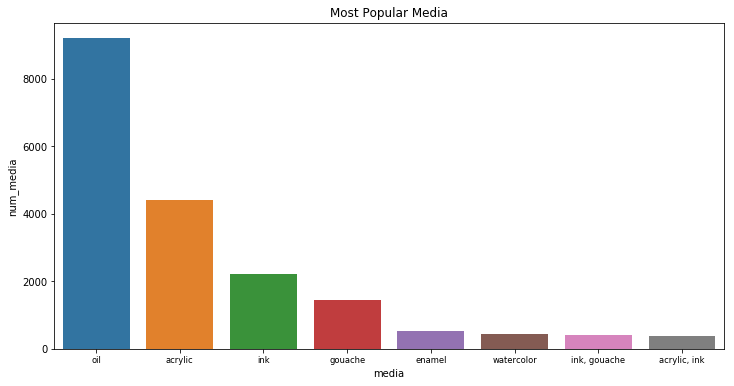

In [42]:
N = 8 # plot top 8 excluding empty str
art_media = art_media[1:N+1]

plt.figure(figsize=(12,6))
plt.title('Most Popular Media')
sns.barplot(art_media['media'],
            art_media['num_media'])
plt.xticks(range(N), 
           art_media['media'], 
           size='small')
plt.show()

### Execution year

In [0]:
nlp = spacy.load('en_core_web_sm')

exe_yr_pat = [
    [{'LOWER': {'IN': ['executed', 'painted']}},
     {"POS": "ADP"}, 
     {"POS": "NUM"},
     {"POS": {'IN': ['PROPN', 'SYM']}, "OP": "*"}, 
     {"POS": "NUM", "OP": "*"},
     {'POS': 'SYM', "OP": "*"},
     {"POS": "NUM", "OP": "*"},
     {"POS": "PROPN", "OP": "*"},
     {"POS": "NUM", "OP": "*"}]
]

In [0]:
def pipe_matcher(matcher, docs):
    for doc in docs:
        matches = matcher(doc)
        if len(matches) > 0:
            match_id, start, end = matches[-1]    
            span = doc[start:end]  
            yield span.text    
            
        else:
            yield ''
    

In [45]:
df.dropna(subset=['item_des'], inplace=True)

len(df)

48343

In [0]:
docs = nlp.pipe(df['item_des'])

matcher = Matcher(nlp.vocab)
matcher.add("exe_yr", None, *exe_yr_pat)  # add patterns

mt = pipe_matcher(matcher, docs)

In [47]:
%%time
df['executed_yr'] = list(mt)

CPU times: user 5min 23s, sys: 3.58 s, total: 5min 26s
Wall time: 5min 27s


In [0]:
def find_year_exe(s):
    try: return abs(int(s.split(' ')[-1])) # get the year
    except: return np.nan
      
df['year_exe'] = df['executed_yr'].apply(find_year_exe)

In [49]:
t = df['year_exe'].value_counts()
outliers = t[(t.index > 2020) | (t.index < 1000)].index

outliers

Float64Index([19993.0, 205.0], dtype='float64')

Apparently the paintings are done on the year 205 and 19993. Check if this is the case below.

In [50]:
df[df['year_exe'].isin(outliers)]

,title,auction_id,auction_loc,sale,currency,parent,auction_start,auction_end,item_id,item_name,item_past,artist,item_des,item_prov,img_url,exchange_rate,low_est,high_est,realized_price,p_h,avg_h,dims,dims_float,media,art_media,executed_yr,year_exe
12169,Post-War and Contemporary Art,3062,Amsterdam,6238500,EUR,Post-War-and-Contemporary-Art-25906,2016-04-20,2016-04-21,259,Untitled (Arrest Horizonthal),Guy Van Bossche (b. 1952),Guy Van Bossche,"""Guy Van Bossche (b. 1952) Untitled (Arrest H...","Mulier Mulier Gallery, Knokke. Acquired from t...",https://www.christies.com/img/LotImages/2016/A...,0.881915,8000.0,12000.0,12500.0,bcc6c33c9c1bc12b,ffffff9f87820879,140 x 160cm,"[140.0, 160.0]",{oil},oil,Painted in 205,205.0
28410,Property of the Scheringa Museum of Realist Art,3020,Amsterdam,2880075,EUR,Property-of-the-Scheringa-23778,2012-09-18,2012-09-18,84,Still life with a red box,Dennis Mogelgaard (b. 1959),Dennis Mogelgaard,"""Dennis Mogelgaard (b. 1959) Still life with...","Galerie Mokum, Amsterdam, where acquired by th...",https://www.christies.com/img/LotImages/2012/A...,0.777644,800.0,1200.0,3750.0,c1eb3db46a992562,fffffffd74020000,60.5 x 73 cm,"[60.5, 73.0]",{oil},oil,Painted in 19993,19993.0


Looks like there is a typo in the description. Change them manually.

In [0]:
# change manually in place
df.iloc[12169, df.columns.get_loc('year_exe')] = 2005
df.iloc[28410, df.columns.get_loc('year_exe')] = 1993

In [0]:
# strftime('%Y')
df['age'] = df['auction_end'].apply(lambda o: int(o.split('-')[0])) -\
            df['year_exe']

In [53]:
df['age'].describe()

count    27439.000000
mean        27.040490
std         19.353469
min          0.000000
25%         10.000000
50%         24.000000
75%         42.000000
max        223.000000
Name: age, dtype: float64

The attempt to parse all the year for the artwork is executed was not succeful. Looking at the subset, the below will try to determine if there is any correlationship between the "age" of the artwork and price the artwork was sold.

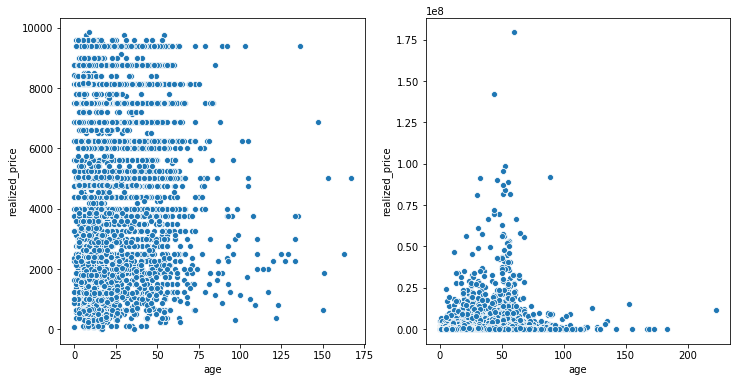

In [54]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

sns.scatterplot(x="age", 
                y="realized_price",
                ax=ax1,
                data=df[df['realized_price'] < 10_000])

sns.scatterplot(x="age", 
                y="realized_price",
                ax=ax2,
                data=df[df['realized_price'] >= 10_000])

plt.show()

### Location


Popular auction locations?

In [0]:
df.replace('London, South Kensington', 'London', inplace=True)

loc_auctions = (df.groupby('auction_id')
                  .head(1)['auction_loc']
                  .value_counts()
                  .reset_index()
                  .rename(columns={'index': 'location',
                                   'auction_loc': 'num_auctions'}))

loc_auctions = loc_auctions.groupby('location').sum().reset_index()

loc_auctions = loc_auctions.sort_values('num_auctions', ascending=False)

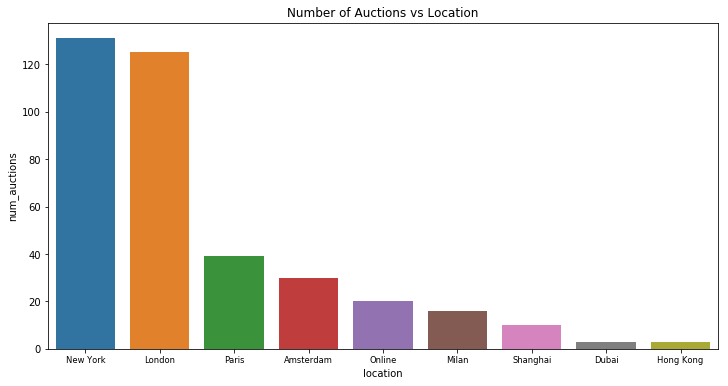

In [56]:
plt.figure(figsize=(12,6))
plt.title('Number of Auctions vs Location')
sns.barplot(loc_auctions.location,
            loc_auctions.num_auctions)
plt.xticks(range(len(loc_auctions.location)), 
           loc_auctions.location, 
           size='small')
plt.show()

New York is the most popular location for auctions, followed by London and Paris.

### Artists


Who are the popular artists, i.e., sold the most paintings?

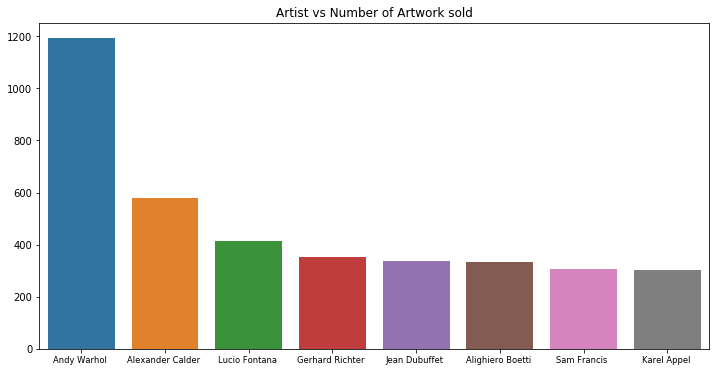

In [57]:
popular_artist = df['artist'].value_counts().head(8) # top 8 artist

plt.figure(figsize=(12,6))
plt.title('Artist vs Number of Artwork sold')
sns.barplot(popular_artist.index,
            popular_artist.values)
plt.xticks(range(len(popular_artist.index)), 
           popular_artist.index, 
           size='small')
plt.show()

Year of artist?

In [0]:
from spacy.matcher import Matcher

nlp = spacy.load('en_core_web_sm')

artist_yr = [
    [{'POS': 'NUM'},
     {'POS': 'SYM', "OP": "*"}, 
     {'POS': 'NUM', "OP": "*"}],
    
    [{"LOWER": {"REGEX": "[NnBb.]\d\d\d\d"}}]
]

def pipe_matcher(matcher, docs):
    for doc in docs:
        matches = matcher(doc)
        
        if len(matches) > 0:
            match_id, start, end = matches[0]    
            span = doc[start:end]
            yield span.text    
            
        else:
            yield ''   

In [0]:
df.dropna(subset=['item_past'], inplace=True)
docs = nlp.pipe(df['item_past'])

matcher = Matcher(nlp.vocab)
matcher.add("art_yr", None, *artist_yr)  # add patterns

mt = pipe_matcher(matcher, docs)

In [60]:
%%time
df['artist_yr'] = list(mt)

CPU times: user 1min 3s, sys: 565 ms, total: 1min 4s
Wall time: 1min 4s


In [0]:
def fix_artist_yr(s):
    num = -1
    if len(s) == 4: num = s    
    if s.find('–') != -1: num = s.split('–')[-1]
    elif s.find('-') != -1: num = s.split('-')[-1]
    elif s.find('/') != -1: num = s.split('/')[-1]
    elif s.find('b.') != -1: num = s.split('.')[-1]
    elif s.find('B.') != -1: num = s.split('.')[-1]
    elif s.find('n.') != -1: num = s.split('.')[-1]
    elif s.find('N.') != -1: num = s.split('.')[-1]
                
    try:
        return int(num)
    except Exception as e:
        return -1

In [62]:
df['artist_last_yr'] = df['artist_yr'].apply(fix_artist_yr)

artist_years = df.loc[(df['artist_last_yr'] > 1000) &
                      (df['artist_last_yr'] < 2020)]

pct = len(artist_years) / len(df) * 100
print('Percent of valid artist\'s years: {:.2f}%'.format(pct))

Percent of valid artist's years: 86.76%


In [0]:
artist_years['year_quantile'] = pd.qcut(artist_years['artist_last_yr'],
                                        10)

g = (artist_years.groupby(['year_quantile'])['realized_price']
                 .mean()
                 .reset_index())

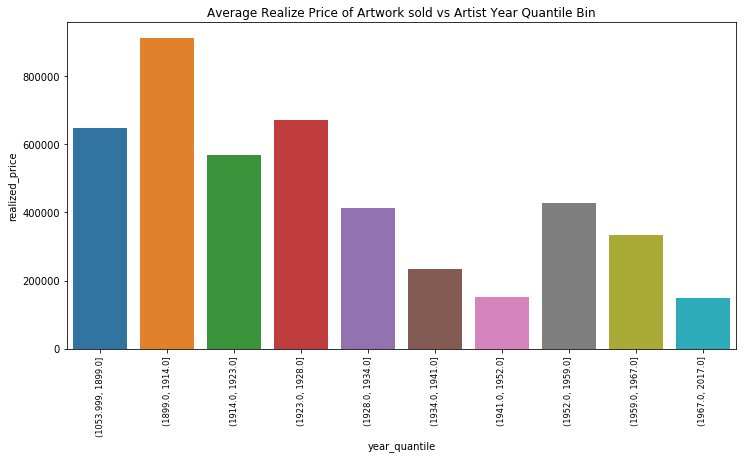

In [64]:
plt.figure(figsize=(12,6))
plt.title('''Average Realize Price of Artwork sold 
             vs Artist Year Quantile Bin''')
sns.barplot(x='year_quantile', 
            y='realized_price',
            data=g)
plt.xticks(range(len(g)), 
           g['year_quantile'], 
           rotation=90,
           size='small')
plt.show()

Most valuable artist based on the average price of artwork sold.

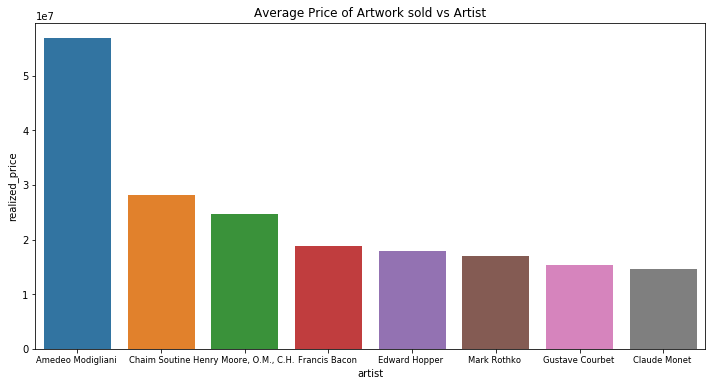

In [65]:
val_art = (df.groupby('artist')['realized_price']
              .mean()
              .sort_values(ascending=False))

val_art = val_art.reset_index()

val_art = val_art[1:9] # excludes Da Vinci's most expensive painting

plt.figure(figsize=(12,6))
plt.title('Average Price of Artwork sold vs Artist')
sns.barplot(val_art['artist'],
            val_art['realized_price'])
plt.xticks(range(8), 
           val_art['artist'], 
           size='small')
plt.show()

### Prices

Before working on the prices, convert all prices to USD to ease analysis.

In [0]:
def price_in_usd(df, p):
    
    # check if none of the price is below 0
    negative_p = (df[p] < 0).sum()
    
    assert(negative_p == 0)
    
    # count number of nan
    before_nan_p = (df[p].isna().sum())
    
    # use -999 as placeholder to replace nan
    df[p].replace(np.nan, -999, inplace=True)
    
    # convert price
    df[p] = df[p] / df['exchange_rate']
    
    # convert negative price back to nan
    def convert_nan(p):
        if p < 0: return np.nan
        else: return p

    df[p] = df[p].apply(convert_nan)  
    
    # check if number of nan is same as before
    after_nan_p = (df[p].isna().sum())
                   
    assert(before_nan_p == after_nan_p)

In [0]:
price_in_usd(df, 'low_est')
price_in_usd(df, 'high_est')
price_in_usd(df, 'realized_price')

Check distribution of realized prices.

In [68]:
df.dropna(subset=['realized_price'], inplace=True)

# winsorization to the 95th and 5th percentile
p5 = df['realized_price'].quantile(.05)
p95 = df['realized_price'].quantile(.95)

between_5_and_95 = df.loc[(df['realized_price'] > p5) &
                          (df['realized_price'] < p95)]

print('Number of realized_prices shown:', len(between_5_and_95))

Number of realized_prices shown: 42351


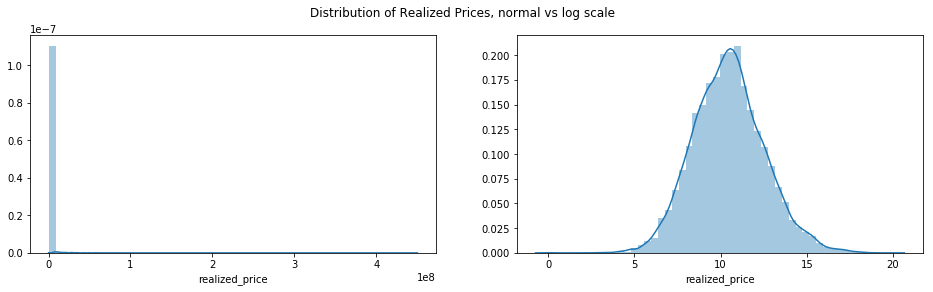

In [69]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

f.suptitle('Distribution of Realized Prices, normal vs log scale', 
           fontsize=12)

sns.distplot(df['realized_price'],
             ax=ax1)

sns.distplot(np.log(df['realized_price']),
             ax=ax2)

plt.show()

Of course, paintings with a realized price of greater than the 95th percentile deserves a closer look.

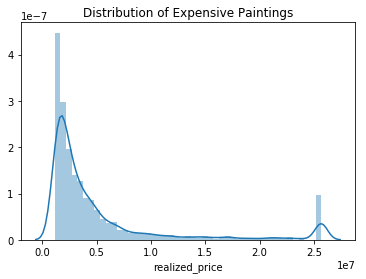

In [70]:
expensive = df.loc[df['realized_price'] > p95]

expensive95 = expensive['realized_price'].quantile(.95)

expensive.loc[expensive['realized_price'] > expensive95] = expensive95

plt.title('Distribution of Expensive Paintings')
sns.distplot(expensive['realized_price'])
plt.show()

What items have a lower realized price than the estimated sale price?

In [0]:
df.reset_index(drop=True, inplace=True)

In [83]:
df['underval'] = df['low_est'] - df['realized_price']

df.sort_values('underval', ascending=False).head(3)

,title,auction_id,auction_loc,sale,currency,parent,auction_start,auction_end,item_id,item_name,item_past,artist,item_des,item_prov,img_url,exchange_rate,low_est,high_est,realized_price,p_h,avg_h,dims,dims_float,media,art_media,executed_yr,year_exe,age,artist_yr,artist_last_yr,underval,overval,year
35848,Post-War and Contemporary Evening Sale,2355,New York,272873000,USD,Post-War-and-Contemporary-Evening-22592,2010-11-10,2010-11-10,8,Big Campbell's Soup Can with Can Opener (Veget...,Andy Warhol (1928-1987),Andy Warhol,"""Andy Warhol (1928-1987) Big Campbell's Soup...","Stable Gallery, New York Mr. and Mrs. Burton T...",https://www.christies.com/img/LotImages/2010/N...,1.0,30000000.0,50000000.0,23882500.0,b9e2c61919f6b426,fcf1e70f0f0f1f1f,182.9 x 132.1 cm,"[182.9, 132.1]",{},,Painted in 1962,1962.0,48.0,1928,1928,6117500.0,-26117500.0,2010
33596,Post-War and Contemporary Art Evening Sale,2440,New York,301683000,USD,Post-War-and-Contemporary-Art-23048,2011-05-11,2011-05-11,16,Self-Portrait,Andy Warhol (1928-1987),Andy Warhol,"""Andy Warhol (1928-1987) Self-Portrait sig...","Anthony d'Offay, London Galerie Beyeler, Basel...",https://www.christies.com/img/LotImages/2011/N...,1.0,30000000.0,40000000.0,27522500.0,ae2fd1919194cec5,ff8181818191fffd,271.2 x 270.5 cm,"[271.2, 270.5]",{ink},ink,Painted in 1986,1986.0,25.0,1928,1928,2477500.0,-12477500.0,2011
21452,A Dialogue Through Art: Works from the Jan Kru...,3442,New York,92533000,USD,A-Dialogue-Through-Art-24639,2013-11-04,2013-11-04,15,Tête de Diego au col roulé,Alberto Giacometti (1901-1966),Alberto Giacometti,'Alberto Giacometti (1901-1966) Tête de Dieg...,"M. and Mme Aimé Maeght, Paris (acquired from t...",https://www.christies.com/img/LotImages/2013/N...,1.0,6000000.0,9000000.0,3973000.0,e6c69939c51ed861,ffe7e7e7c38181ff,,NaN,{},,executed in 1951,1951.0,62.0,1901,1901,2027000.0,-5027000.0,2013


A look at the first and second undervalued paintings.

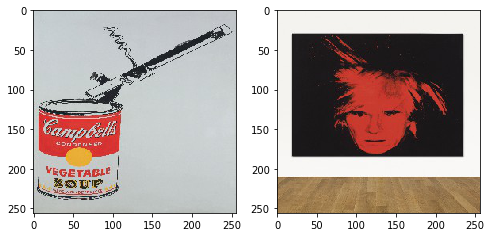

In [84]:
plot2(df.iloc[35848]['img_url'], df.iloc[33596]['img_url'])

What items have a significant higher realized price than the estimated sale price?

In [85]:
df['overval'] = df['realized_price'] - df['high_est']

df.sort_values('overval', ascending=False).head(3)

,title,auction_id,auction_loc,sale,currency,parent,auction_start,auction_end,item_id,item_name,item_past,artist,item_des,item_prov,img_url,exchange_rate,low_est,high_est,realized_price,p_h,avg_h,dims,dims_float,media,art_media,executed_yr,year_exe,age,artist_yr,artist_last_yr,underval,overval,year
29107,Post-War and Contemporary Art Evening Sale,2557,New York,388488000,USD,Post-War-and-Contemporary-Art-23535,2012-05-08,2012-05-08,20,"Orange, Red, Yellow",Mark Rothko (1903-1970),Mark Rothko,"""Mark Rothko (1903-1970) Orange, Red, Yellow...","Marlborough-Gerson Gallery, Inc., New York Mar...",https://www.christies.com/img/LotImages/2012/N...,1.0,35000000.0,45000000.0,86882500.0,fe6b85c491c19595,ff818181818181ff,236.2 x 206.4 cm,"[236.2, 206.4]",{oil},oil,Painted in 1961,1961.0,51.0,1903,1903,-51882500.0,41882500.0,2012
43737,Post-War and Contemporary Art Evening Sale,1834,New York,384654400,USD,Post-War-and-Contemporary-Art-21339,2007-05-16,2007-05-16,15,Green Car Crash (Green Burning Car I),Andy Warhol (1928-1987),Andy Warhol,'Andy Warhol (1928-1987) Green Car Crash (Gr...,"Galerie Ileana Sonnabend, Paris Gian Enzo Sper...",https://www.christies.com/img/LotImages/2007/N...,1.0,25000000.0,35000000.0,71720000.0,af5b2db959af8040,8888b383c3878303,228.6 x 203.2 cm,"[228.6, 203.2]","{acrylic, ink}","acrylic, ink",Painted in 1963,1963.0,44.0,1928,1928,-46720000.0,36720000.0,2007
23472,Post-War & Contemporary Evening Sale,2785,New York,495021500,USD,Post-War-and-Contemporary-Evening-24344,2013-05-15,2013-05-15,18,"Number 19, 1948",Jackson Pollock (1912-1956),Jackson Pollock,"""Jackson Pollock (1912-1956) Number 19, 1948...","Janet Chase Hauck, New York Anon. sale; Christ...",https://www.christies.com/img/LotImages/2013/N...,1.0,25000000.0,35000000.0,58363750.0,bfe3c094919fd058,ff818181818181ff,78.4 x 57.4 cm,"[78.4, 57.4]","{enamel, oil}","enamel, oil",Painted in 1948,1948.0,65.0,1912,1912,-33363750.0,23363750.0,2013


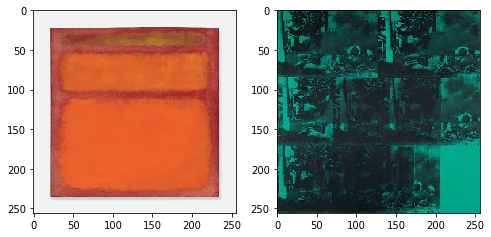

In [86]:
plot2(df.iloc[29107]['img_url'], df.iloc[43737]['img_url'])

What are the most expensive items?

In [87]:
df.sort_values('realized_price', ascending=False).head(3)

,title,auction_id,auction_loc,sale,currency,parent,auction_start,auction_end,item_id,item_name,item_past,artist,item_des,item_prov,img_url,exchange_rate,low_est,high_est,realized_price,p_h,avg_h,dims,dims_float,media,art_media,executed_yr,year_exe,age,artist_yr,artist_last_yr,underval,overval,year
5106,Post-War & Contemporary Art Evening Sale,14995,New York,785942250,USD,Post-War-and-Contemporary-Art-27244,2017-11-15,2017-11-15,9,Salvator Mundi,Leonardo da Vinci (1452-1519),Leonardo Da Vinci,'Leonardo da Vinci (1452-1519) Salvator Mundi ...,(Possibly) Commissioned after 1500 by King Lou...,https://www.christies.com/img/LotImages/2017/N...,1.0,NaN,NaN,450312500.0,ea6cb792c136ccc8,ff819991f95587ff,65.7 x 45.7 cm,"[65.7, 45.7]",{oil},oil,,NaN,NaN,1452,1452,NaN,NaN,2017
16711,Looking Forward to the Past,3739,New York,705858000,USD,Looking-Forward-to-the-25299,2015-05-11,2015-05-11,8,Les femmes d'Alger (Version 'O'),Pablo Picasso (1881-1973),Pablo Picasso,"""Pablo Picasso (1881-1973) Les femmes d'Alger...",Galerie Louise Leiris (Daniel-Henry Kahnweiler...,https://www.christies.com/img/LotImages/2015/N...,1.0,NaN,NaN,179365000.0,ba61c59bd4ded042,ff818181858d81ff,114 x 146.4 cm,"[114.0, 146.4]",{oil},oil,Painted on 14 February 1955,1955.0,60.0,1881,1881,NaN,NaN,2015
14273,The Artist's Muse: A Curated Evening Sale,3789,New York,491352000,USD,The-Artists-Muse-A-25343,2015-11-09,2015-11-09,8,Nu couché,Amedeo Modigliani (1884-1920),Amedeo Modigliani,'Amedeo Modigliani (1884-1920) Nu couché sig...,"Léopold Zborowski, Paris. Jonas Netter, Paris....",https://www.christies.com/img/LotImages/2015/N...,1.0,NaN,NaN,170405000.0,804767338bf96b8c,60207a7e7f4fc703,59.9 x 92 cm,"[59.9, 92.0]",{oil},oil,Painted in 1917-1918,NaN,NaN,1884,1884,NaN,NaN,2015


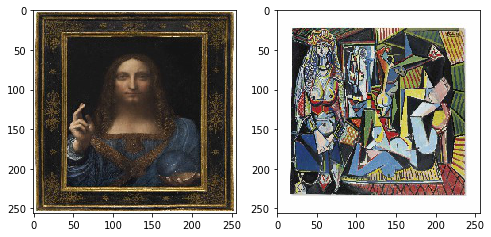

In [88]:
plot2(df.iloc[5106]['img_url'], df.iloc[16711]['img_url'])

### Trends
Trend for the items sold?

In [0]:
df['auction_start'] = pd.to_datetime(df['auction_start'])
df['auction_end'] = pd.to_datetime(df['auction_end'])

In [0]:
df['year'] = df['auction_end'].apply(lambda o: o.strftime('%Y'))

year_sales = df.groupby('year')['realized_price'].sum().reset_index()

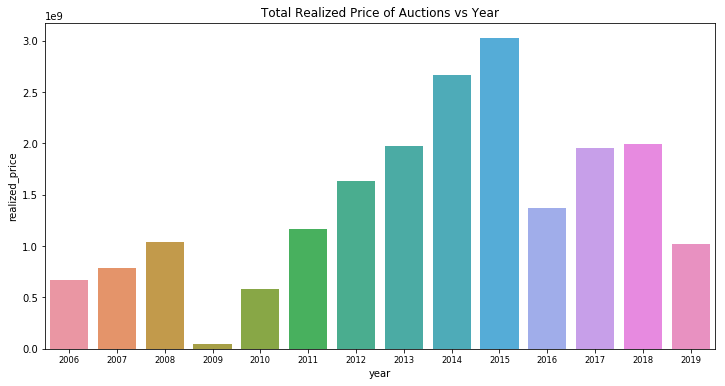

In [91]:
plt.figure(figsize=(12,6))
plt.title('Total Realized Price of Auctions vs Year')
sns.barplot(year_sales['year'],
            year_sales['realized_price'])
plt.xticks(range(len(year_sales['year'])), 
           year_sales['year'], 
           size='small')
plt.show()

Oh poor 2009 - guess the financial crisis certainly hit the art auction market.

Next consider the number of items sold based on year and location.

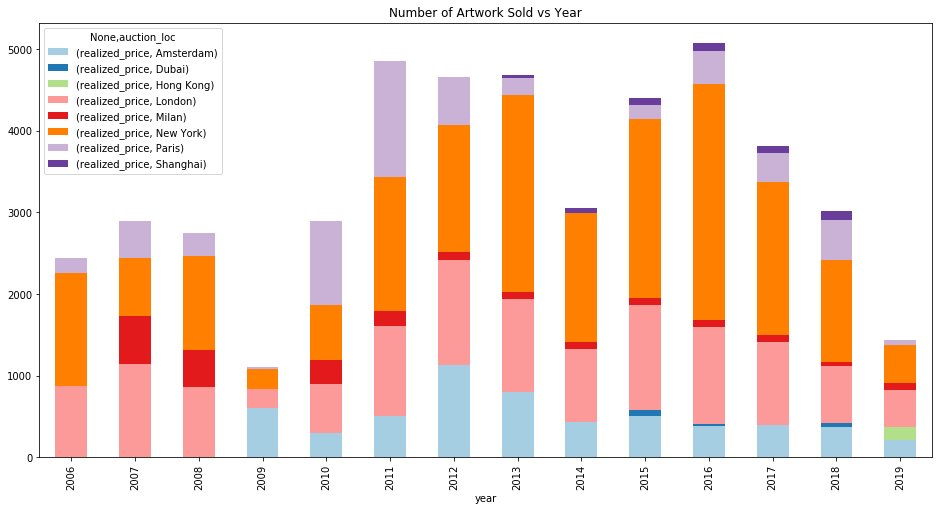

In [92]:
y_loc_sales = df.groupby(['year', 'auction_loc'])['realized_price'].count()

y_loc_sales = y_loc_sales.reset_index().pivot(columns='auction_loc', 
                                              index='year')

y_loc_sales.plot(kind='bar', 
                 stacked=True,
                 title='Number of Artwork Sold vs Year',
                 colormap=ListedColormap(sns.color_palette("Paired", 10)),
                 figsize=(16,8))
plt.show()